In [1]:
#http://people.bu.edu/andasari/courses/numericalpython/Week11Lecture19/PythonFiles/adi_2d_oop.py


In [2]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [8]:
class ADImethod:
    
    def __init__(self, M, maxt, structure):
        self.M = M
        self.x0 = 0
        self.xf = 1
        self.y0 = 0
        self.yf = 1
        self.maxt = maxt
        self.dt = 0.005
        self.D_muscle= 1/6
        self.D_bone=self.D_muscle/4
        self.h = 1/self.M
        self.r_muscle = self.D_muscle*self.dt/(2*self.h**2)
        self.r_bone = self.D_bone*self.dt/(2*self.h**2)
        self.structure=structure
        self.generateGrid()
        self.lhsMatrixA()
        self.rhsMatrixA()
        self.heatsourceQ()
        

            
    def generateGrid(self):
        self.X, self.Y = np.meshgrid(np.linspace(self.x0, self.xf, self.M), np.linspace(self.y0, self.yf,self. M))
        ic01 = np.logical_and(self.X >= 0, self.X <= 1)
        ic02 = np.logical_and(self.Y >= 0, self.Y <= 1)
        ic0 = np.multiply(ic01, ic02)
        self.U = ic0*37
    
        
        
        
        
    def heatsourceQ(self):  #heating
        self.Q = np.zeros((self.M, self.M))
        r2 = 0.04
        for i in range(self.M):
            for j in range(self.M):
                p2 = (i*self.h-1/2)**2 + (j*self.h-1/2)**2
                if p2 < r2:
                    self.Q[i,j] = 8*np.exp(-100*p2)
        self.Q=np.multiply( self.structure*((105/5)-1)+1, self.Q)
        plt.imshow(self.Q)
        plt.show()
    
    def lhsMatrixA(self):
        structure_columns=self.structure.flatten('C')
        maindiag = np.ones( self.M**2)
        maindiag[structure_columns!=0]=(1+2*self.r_bone)
        maindiag[structure_columns==0]=(1+2*self.r_muscle)
        offdiag1 = np.ones(self.M**2-1)
        offdiag1[structure_columns[:-1]!=0]=-self.r_bone
        offdiag1[structure_columns[:-1]==0]=-self.r_muscle
        offdiag2 = np.ones( self.M**2-1)
        offdiag2[structure_columns[1:]!=0]=-self.r_bone
        offdiag2[structure_columns[1:]==0]=-self.r_muscle
        a = maindiag.shape[0]
        diagonals = [maindiag, offdiag2, offdiag1]
        self.A = sparse.diags(diagonals, [0, -1, 1], shape=(a, a)).toarray()
        
        pos0 = np.arange(self.M-1, self.M**2-M+1, self.M)
        for i in range(len(pos0)):
            self.A[pos0[i], pos0[i]+1]=0
            self.A[pos0[i]+1, pos0[i]]=0
            
        pos1 = np.arange(0,self.M**2,self.M)
        for i in range(len(pos1)):
            if structure_columns[pos1[i]]!=0:
                self.A[pos1[i], pos1[i]] = 1 + self.r_bone
            else: 
                self.A[pos1[i], pos1[i]] = 1 + self.r_muscle
            
        pos2 = np.arange(self.M-1, self.M**2, self.M)
        
        for j in range(len(pos2)):
            if structure_columns[pos2[j]]!=0:
                self.A[pos2[j], pos2[j]] = 1 + self.r_bone
            else:
                self.A[pos2[j], pos2[j]] = 1 + self.r_muscle
                
#         plt.imshow(self.A)
#         plt.show()   
        
    
    def rhsMatrixA(self):
        structure_rows=self.structure.flatten('F')
        maindiag = np.ones(self.M**2)
        maindiag[structure_rows!=0]=(1-self.r_bone)
        maindiag[structure_rows==0]=(1-self.r_muscle)
        offdiag1 = np.ones( self.M**2-M)
        offdiag1[structure_rows[:-self.M]!=0]=self.r_bone
        offdiag1[structure_rows[:-M]==0]=self.r_muscle
        offdiag2 = np.ones( self.M**2-self.M)
        offdiag2[structure_rows[self.M:]!=0]=self.r_bone
        offdiag2[structure_rows[self.M:]==0]=self.r_muscle
        a = maindiag.shape[0]
        diagonals = [maindiag, offdiag2, offdiag1]
        self.A_rhs = sparse.diags(diagonals, [0, -self.M, self.M], shape=(a, a)).toarray()
        
        pos0 = np.arange(self.M-1, self.M**2-M+1, self.M)
        for i in range(len(pos0)):
            self.A_rhs[pos0[i], pos0[i]+1]=0
            self.A_rhs[pos0[i]+1, pos0[i]]=0
            
        pos3 = np.arange(self.M, self.M**2-self.M)
        
        for k in range(len(pos3)):            
            if structure_rows[pos3[k]]!=0:
                self.A_rhs[pos3[k], pos3[k]] = 1 - 2*self.r_bone
            else:
                self.A_rhs[pos3[k], pos3[k]] = 1 - 2*self.r_muscle
#         plt.imshow(self.A_rhs)
#         plt.show()   
#         print(self.A_rhs)        
    def solve_and_plot(self): # Important bit!!!!!!!!!!!!!!
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        #ax.set_zlim(0, 1)
        tc = 0
        nstep = round(self.maxt/self.dt)
        while tc < nstep:
            b1 = np.flipud(self.U).reshape(self.M**2, 1)
            sol = np.linalg.solve(self.A, np.matmul(self.A_rhs, b1))
            self.U = np.flipud(sol).reshape(self.M, self.M)
            
            b2 = np.flipud(self.U).reshape(self.M**2, 1)
            sol = np.linalg.solve(self.A, np.matmul(self.A_rhs, b2))
            self.U = np.flipud(sol).reshape(self.M, self.M)
            self.U=self.U+self.Q*self.dt
            self.U[0,:]=np.ones(self.M)*37
            self.U[-1,:]=np.ones(self.M)*37
            self.U[:,-1]=np.ones(self.M)*37
            self.U[:,0]=np.ones(self.M)*37
            tc += 1
            
        ax.plot_surface(self.X, self.Y, self.U, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
        plt.tight_layout()
        plt.show()
        plt.imshow(self.U)
        plt.show()
#         print(np.min(self.U))

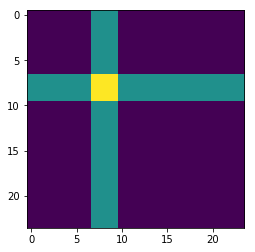

In [9]:
M=24
structure=np.zeros((M,M))
structure[:,int(0.3*M):int(0.45*M)]=structure[:,int(0.3*M):int(0.45*M)]+1
structure[int(0.3*M):int(0.45*M)]=structure[int(0.3*M):int(0.45*M)]+1
plt.imshow(structure)
plt.show()

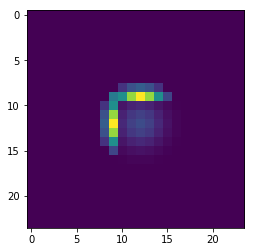

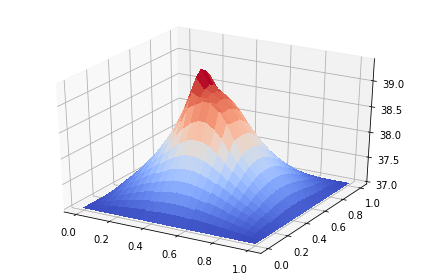

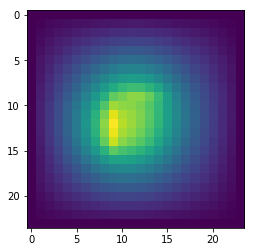

In [10]:
def main():
    simulator = ADImethod(M, 40, structure)
    simulator.solve_and_plot()
    
if __name__ == "__main__":
    main()
    

In [247]:
np.ones(2)

array([1., 1.])